In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.interpolate import interp1d

# sionna imports
from sionna.constants import PI
from sionna.rt.antenna import polarization_model_2, polarization_model_1
from sionna.rt.antenna import Antenna, visualize

Define our `msi_reader` function

In [4]:
def msi_file_reader(msi_path):
    """
    This function reads the most relevant information out of an .msi file
    to further reconstruct the 3D radiation pattern of a given antenna

    Input:
    - msi_path (str) --> A sting containing the path to the .msi file

    Otuputs:
    - horizontal_gains (tf.constant)
    - vertical_gains (tf.constant)
    - antenna_gain (float)
    """

    # Initialize lists to hold the angles and gains for horizontal and vertical patterns
    horizontal_gains = []
    vertical_gains = []

    # Parse the .msi file
    with open(msi_path, 'r') as file:
        for line in file: # let us firstly search for the antenna gain
            # Use regex to match the 'GAIN' keyword and extract the value
            match = re.search(r"GAIN\s+([\d.]+)\s*dBd", line, re.IGNORECASE)
            if match:
                antenna_gain = float(match.group(1))
                antenna_gain = antenna_gain + 2.15 # turn dBds into dBis
                break
            else:
                print(f'No antenna GAIN detected !!')

        # let us extract both horizontal and vertical gains
        lines = file.readlines()
        horizontal_section = False
        vertical_section = False

        for line in lines:
            # Identify sections
            if "HORIZONTAL" in line:
                horizontal_section = True
                vertical_section = False
                continue
            elif "VERTICAL" in line:
                vertical_section = True
                horizontal_section = False
                continue

            # Parse angles and gains
            if horizontal_section:
                _, gain = map(float, line.strip().split())
                horizontal_gains.append(gain)
            elif vertical_section:
                _, gain = map(float, line.strip().split())
                vertical_gains.append(gain)

        # let us convert both gain lists into tensorflow
        # horizontal_gains = tf.constant(horizontal_gains)
        # vertical_gains = tf.constant(vertical_gains)
        horizontal_gains = np.array(horizontal_gains)
        vertical_gains = np.array(vertical_gains)

    return antenna_gain, horizontal_gains, vertical_gains

Define our custom pattern and our reconstruction algorithm. In this case we have implemented the cross-weighted algorithm

In [5]:
def cross_weighted_algorithm(gain_theta, gain_phi):
    '''
    This function takes as input both horizontal and vertical converted
    angles as well as their associated gains. The aim is to reconstruct in
    3D the radiation pattern, given its .msi file.
    The function outputs the antenna gain on both angles.

    Inputs:
    - antenna_gain (float) -> The gain of the antenna, read from the .msi file
    - horizontal_gains (tf.constant) -> A file containing the gains from the
        horizontal plane of the antenna.
    - vertical_gains (tf.constant) -> A file containing the gains from the
        vertical plane of the antenna.

    Outputs:
    - G_w_theta_phi () -> Final gains of the interpolated radiation pattern
    '''

    # Convert to dBs to obtain -> G_H(phi) & G_V(theta)
    gain_theta_dB_n = 10.0 * tf.math.log(gain_theta) / tf.math.log(10.0)
    gain_phi_dB_n = 10.0 * tf.math.log(gain_phi) / tf.math.log(10.0)

    # compute weights (recall that here we must use linear units)
    w1 = gain_theta * (1 - gain_phi)
    w2 = gain_phi * (1 - gain_theta)

    # define the normalization parameter (k=2 for best results)
    k=2

    # compute the final gain
    G_w_theta_phi = gain_phi_dB_n * (w1/tf.pow(tf.pow(w1,k)+tf.pow(w2,k),1/k)) + gain_theta_dB_n * (w2/tf.pow(tf.pow(w1,k)+tf.pow(w2,k),1/k))

    return G_w_theta_phi


# Custom antenna pattern function to be used in Sionna
def custom_pattern(theta, phi, slant_angle=0.0, polarization_model=2, dtype=tf.complex64):

    rdtype = dtype.real_dtype
    k_dB = antenna_gain  # IMPORTANT: the gain should be in dBi not in dBd (previous conversion has been done)
    #k_dB = 0    # Uncomment if you want to normalize the radiattion pattern
    k_dB = tf.cast(k_dB,rdtype)    
    k = 10**(k_dB/10)    
    theta = tf.cast(theta, rdtype)
    phi = tf.cast(phi, rdtype)
    slant_angle = tf.cast(slant_angle, rdtype) # This angle is associate with the polarization

    # Common for SIONNA: (IMPORTANT) same shape does not mean same intervals: (0,pi) and (-pi,pi)
    if not theta.shape== phi.shape: 
        raise ValueError("theta and phi must have the same shape.")
    if polarization_model not in [1,2]:
        raise ValueError("polarization_model must be 1 or 2")

    #Use the interpolator to create a function for each plane
    gain_theta = tf.py_function(func=interp_v, inp=[theta], Tout=tf.float32)
    gain_phi = tf.py_function(func=interp_h, inp=[phi], Tout=tf.float32)

    # Estimation of the 3D pattern using the cross weighted algorithm
    gain_theta_phi_dB_n = cross_weighted_algorithm(gain_theta, gain_phi)

    #Converting from dBn to linear
    g_theta_phi = tf.pow(10.0, gain_theta_phi_dB_n / 10.0) #normalized gain for each per (theta, phi) 
    
    # The values from the MSI files are gain/attenuation values (power)
    # We need to convert from power to field components F = sqrt(P)    
    temp = tf.sqrt(k)*tf.sqrt(g_theta_phi)             
    c = tf.complex(temp, tf.zeros_like(temp))

    # Common step in sionna, this functions obtain the Field components based on the slant angle
    if polarization_model==1:
        return polarization_model_1(c, theta, phi, slant_angle)
    else:
        return polarization_model_2(c, slant_angle)

Here our main code

In [6]:
path = '80010465_0791_x_co.msi'

# let us read the given .msi file
antenna_gain, horizontal_gains, vertical_gains = msi_file_reader(path)

print(f"Este es el tipo de variable de VERTICAL: {type(vertical_gains)}")
print(f"Este es el tipo de variable de HORIZONTAL: {type(horizontal_gains)}")

print(f'This is the antenna GAIN: {antenna_gain}')
print(f'These are the HORIZONTAL GAINS of the antenna: {horizontal_gains}')
print(f'These are the VERTICAL GAINS of the antenna: {vertical_gains}')

# only select gains associated to angles liying on the positive side of the x plane, i.e., 1st and 4th quadrant
temp1 = vertical_gains[0:91][::-1] # sort it out in an inverse manner
temp2 = vertical_gains[270:360][::-1]
filtered_vertical_gains = np.concatenate((temp1, temp2))

# Recall that the .msi file contains attenuations in dB, so the real gain is: G(angles) = Gain - .msi(angles)
g_hor_dB = antenna_gain - horizontal_gains
g_ver_dB = antenna_gain - filtered_vertical_gains

# The normalized values in dB will be -- .msi(angles)
g_hor_dB_n = - horizontal_gains
g_ver_dB_n = - filtered_vertical_gains 

#normalized gain from dB to lineal. Normalized values have been utilized, the gain factor will be added at the end.
gain_v = 10**(g_ver_dB_n/10)
gain_h_temp = 10**(g_hor_dB_n/10) #A temporal variable has been used because we are going to shift the angles to [-pi,pi)

theta = np.linspace(0, 2*PI, 360)

# Shift the theta values to range from -pi to pi
theta_shifted = np.where(theta > PI, theta - 2*PI, theta)
sorted_indices = np.argsort(theta_shifted)

print(f"This is the VALUE of gain_h: {gain_h_temp}")
print(f"This is the SHAPE of gain_h: {np.shape(gain_h_temp)}")

print(f"\nThese are the values of the sorted_indices: {sorted_indices}")
print(f"\nThis is the shape of the variable: sorted_indices: {np.shape(sorted_indices)}")

gain_h = gain_h_temp[sorted_indices]


# Once angles and gain in the MSI file has been parse to be aligned with the spherical coordinate 
# we can work with the variables (theta,phi).
theta_rad = np.linspace(0, PI, 181)  # Zenith angles
phi_rad = np.linspace(-PI, PI, 360)  # Azimuth angles

# Interpolation of each plane: It is required because we only have data with a resolution of one degree from the MSI file
interp_v = interp1d(theta_rad, gain_v, kind='linear', fill_value="extrapolate")
interp_h = interp1d(phi_rad, gain_h, kind='linear', fill_value="extrapolate")

No antenna GAIN detected !!
No antenna GAIN detected !!
Este es el tipo de variable de VERTICAL: <class 'numpy.ndarray'>
Este es el tipo de variable de HORIZONTAL: <class 'numpy.ndarray'>
This is the antenna GAIN: 5.25
These are the HORIZONTAL GAINS of the antenna: [0.000e+00 0.000e+00 1.000e-02 1.000e-02 3.000e-02 4.000e-02 7.000e-02
 9.000e-02 1.200e-01 1.500e-01 1.900e-01 2.300e-01 2.700e-01 3.200e-01
 3.700e-01 4.200e-01 4.700e-01 5.300e-01 5.900e-01 6.500e-01 7.200e-01
 7.800e-01 8.500e-01 9.200e-01 9.800e-01 1.050e+00 1.110e+00 1.180e+00
 1.250e+00 1.320e+00 1.390e+00 1.470e+00 1.550e+00 1.630e+00 1.710e+00
 1.800e+00 1.890e+00 1.980e+00 2.070e+00 2.170e+00 2.270e+00 2.370e+00
 2.470e+00 2.580e+00 2.690e+00 2.790e+00 2.910e+00 3.020e+00 3.140e+00
 3.260e+00 3.380e+00 3.510e+00 3.630e+00 3.760e+00 3.890e+00 4.020e+00
 4.150e+00 4.280e+00 4.410e+00 4.550e+00 4.680e+00 4.810e+00 4.950e+00
 5.090e+00 5.230e+00 5.370e+00 5.520e+00 5.660e+00 5.810e+00 5.960e+00
 6.120e+00 6.280e+00 6.4

Let us now define an `Antenna` object on Sionna, and visualize the custom radiation pattern extracted from the `.msi` file

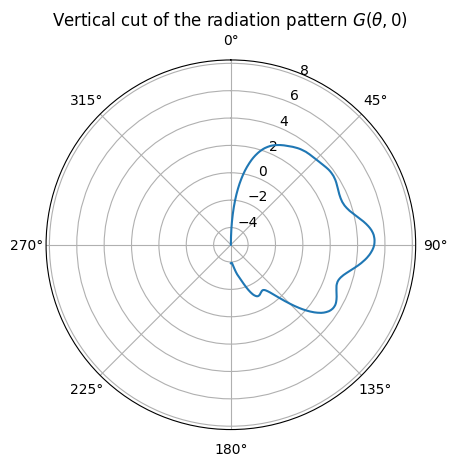

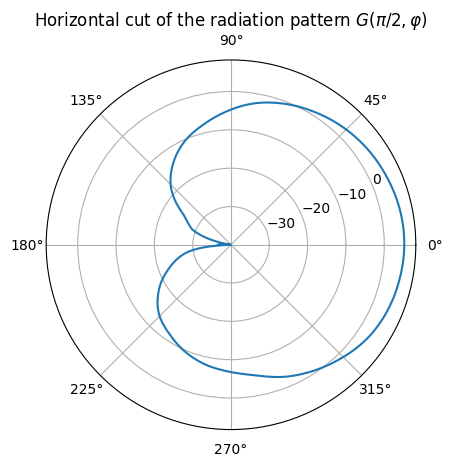

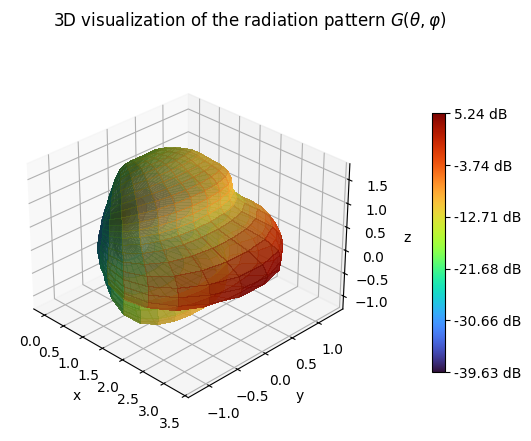

In [7]:
# create the antenna object
antenna = Antenna(pattern=custom_pattern, polarization="H", dtype=tf.complex64)

# visualize the antenna pattern
fig_v, fig_h, fig_3d = visualize(custom_pattern)